<a href="https://colab.research.google.com/github/AinxViin/TA_KlasifikasiKematanganTomat_Android/blob/master/KlasifikasiTomatMobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip DataTomat.zip

Archive:  DataTomat.zip
   creating: DataTomat/
   creating: DataTomat/tomatdata/
   creating: DataTomat/tomatdata/test/
   creating: DataTomat/tomatdata/test/matang/
  inflating: DataTomat/tomatdata/test/matang/135_1-4-_jpg.rf.cc737fdd24e56d51bbfa43fdc5cc74b4.jpg  
  inflating: DataTomat/tomatdata/test/matang/2023-06-22-10-38-54-617_jpg.rf.2756e99f65e24fb6110971f972fc828f.jpg  
  inflating: DataTomat/tomatdata/test/matang/2023-06-22-10-39-25-832_jpg.rf.5e96270d06a67162fd242457ca3a9d05.jpg  
  inflating: DataTomat/tomatdata/test/matang/2023-06-22-10-39-50-241_jpg.rf.b70b5d598ff9887b32f6afa7e076e5da.jpg  
  inflating: DataTomat/tomatdata/test/matang/45_2023-05-14-11-48-15-752_jpg.rf.679cab522b767aad36a7de9e82dc0cb5.jpg  
  inflating: DataTomat/tomatdata/test/matang/45_2023-06-22-10-34-48-017-2_jpg.rf.a8ce5b929f64a61a3c40700976c172dd.jpg  
  inflating: DataTomat/tomatdata/test/matang/90_1-18-_jpg.rf.cd6391de3bdc573af9f473c286eec9cd.jpg  
  inflating: DataTomat/tomatdata/test/matang/90_1-

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import pandas as pd

print("TensorFlow version:", tf.__version__)
tf.keras.utils.set_random_seed(42)


TensorFlow version: 2.19.0


In [ ]:
img_height, img_width = 224, 224
batch_size = 20

train_dir = "DataTomat/tomatdata/train"
val_dir   = "DataTomat/tomatdata/validation"
test_dir  = "DataTomat/tomatdata/test"


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Kelas:", class_names)
num_classes = len(class_names)


Found 1080 files belonging to 3 classes.
Found 135 files belonging to 3 classes.
Found 135 files belonging to 3 classes.
Kelas: ['matang', 'mentah', 'setengahmatang']


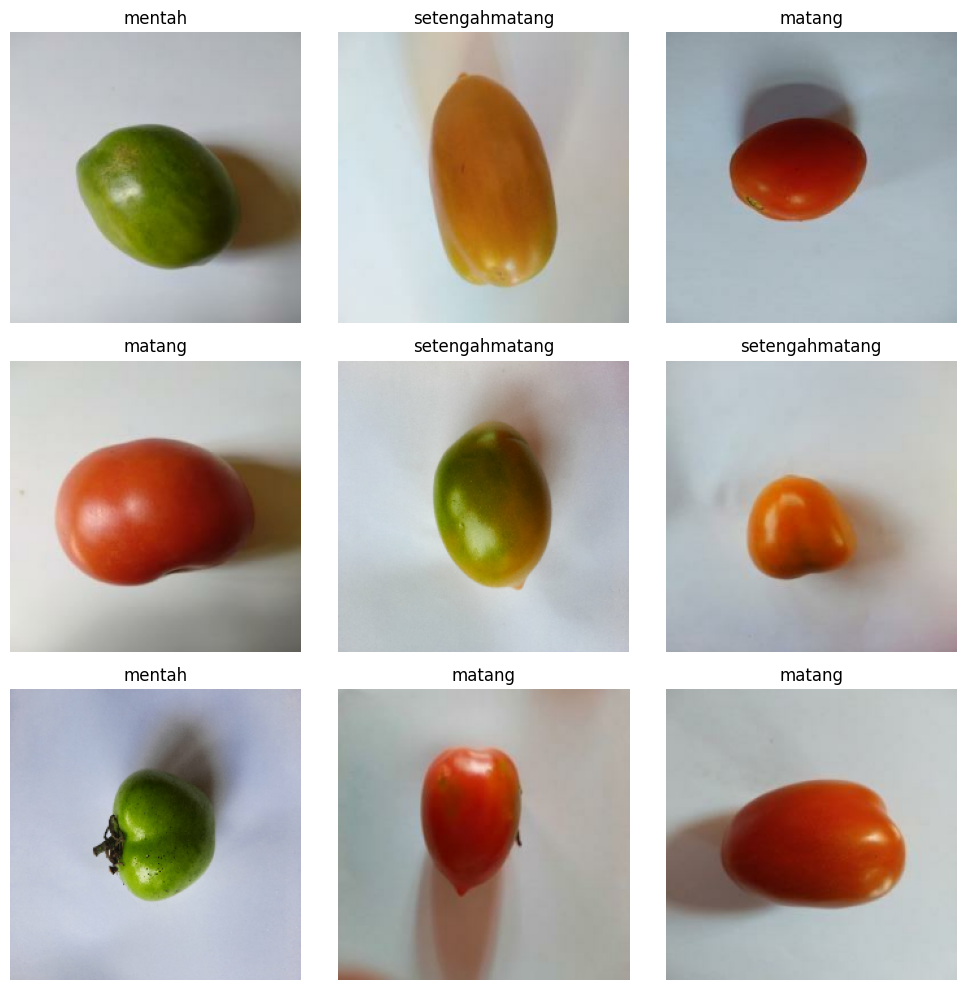

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
base = MobileNetV3Large(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base.trainable = False

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         2,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
initial_lr = 1e-3

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_mnv3_feature_extractor.h5',
    monitor='val_loss',
    save_best_only=True
)

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5982 - loss: 0.8571

54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6010 - loss: 0.8523 - val_accuracy: 0.9556 - val_loss: 0.2557
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9603 - loss: 0.1798

54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 656ms/step - accuracy: 0.9603 - loss: 0.1796 - val_accuracy: 0.9704 - val_loss: 0.1691
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9841 - loss: 0.1061

54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 689ms/step - accuracy: 0.9840 - loss: 0.1060 - val_accuracy: 0.9704 - val_loss: 0.1386
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9829 - loss: 0.0780

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 683ms/step - accuracy: 0.9830 - loss: 0.0779 - val_accuracy: 0.9704 - val_loss: 0.1259
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9942 - loss: 0.0558

54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.9942 - loss: 0.0559 - val_accuracy: 0.9704 - val_loss: 0.1205
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 688ms/step - accuracy: 0.9944 - loss: 0.0397 - val_accuracy: 0.9704 - val_loss: 0.1206
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9995 - loss: 0.0307

54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 678ms/step - accuracy: 0.9995 - loss: 0.0308 - val_accuracy: 0.9704 - val_loss: 0.1134
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9985 - loss: 0.0260

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - accuracy: 0.9984 - loss: 0.0261 - val_accuracy: 0.9704 - val_loss: 0.1106
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9978 - loss: 0.0254

54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 808ms/step - accuracy: 0.9978 - loss: 0.0254 - val_accuracy: 0.9704 - val_loss: 0.1104
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9995 - loss: 0.0219

54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 702ms/step - accuracy: 0.9994 - loss: 0.0220 - val_accuracy: 0.9704 - val_loss: 0.1059


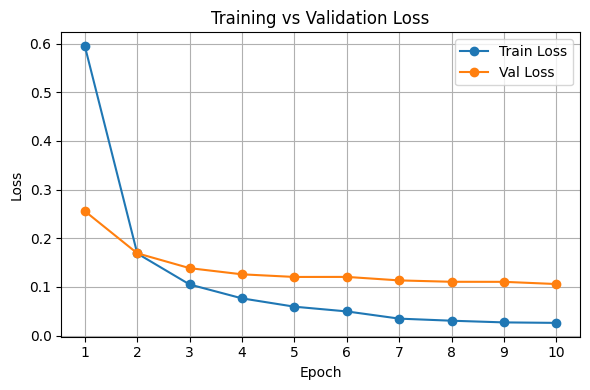

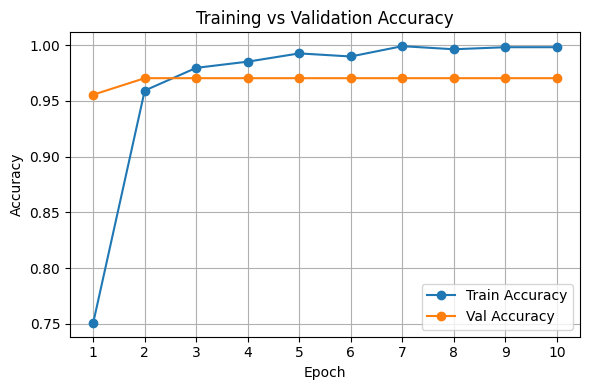

In [ ]:
acc_key = [k for k in history.history.keys()
           if 'accuracy' in k and not k.startswith('val_')][0]
val_acc_key = 'val_' + acc_key

loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history[acc_key]
val_acc  = history.history[val_acc_key]
epochs_range = np.arange(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, loss, marker='o', label='Train Loss')
plt.plot(epochs_range, val_loss, marker='o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.xticks(epochs_range); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, acc, marker='o', label='Train Accuracy')
plt.plot(epochs_range, val_acc, marker='o', label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xticks(epochs_range); plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
print("=== Evaluasi di test set ===")
model.evaluate(test_ds)


=== Evaluasi di test set ===
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step - accuracy: 0.9365 - loss: 0.2376


[0.6906118988990784, 0.8444444537162781]

Accuracy           : 0.8444
Macro   P/R/F      : 0.8586/0.8444/0.8431
Micro   P/R/F      : 0.8444/0.8444/0.8444
Weighted P/R/F     : 0.8586/0.8444/0.8431

=== Classification Report ===
                precision    recall  f1-score   support

        matang       0.78      1.00      0.87        45
        mentah       1.00      0.82      0.90        45
setengahmatang       0.80      0.71      0.75        45

      accuracy                           0.84       135
     macro avg       0.86      0.84      0.84       135
  weighted avg       0.86      0.84      0.84       135


Confusion Matrix (raw counts):
[[45  0  0]
 [ 0 37  8]
 [13  0 32]]


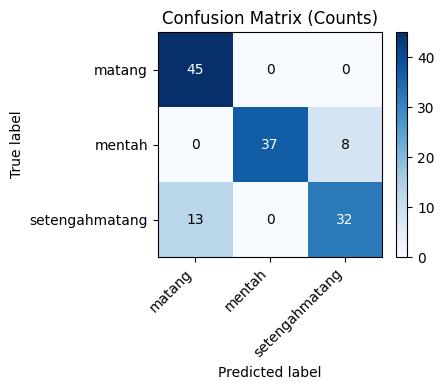

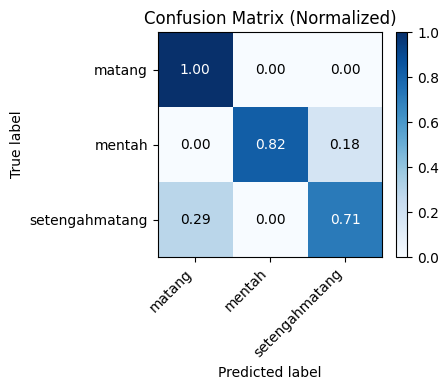

Tersimpan: cm_counts.png dan cm_normalized.png


In [ ]:
# --- Kumpulkan prediksi di test set ---
y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(probs, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Overall metrics ---
acc = accuracy_score(y_true, y_pred)
prec_ma, rec_ma, f1_ma, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
prec_mi, rec_mi, f1_mi, _ = precision_recall_fscore_support(
    y_true, y_pred, average='micro'
)
prec_wt, rec_wt, f1_wt, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"Accuracy           : {acc:.4f}")
print(f"Macro   P/R/F      : {prec_ma:.4f}/{rec_ma:.4f}/{f1_ma:.4f}")
print(f"Micro   P/R/F      : {prec_mi:.4f}/{rec_mi:.4f}/{f1_mi:.4f}")
print(f"Weighted P/R/F     : {prec_wt:.4f}/{rec_wt:.4f}/{f1_wt:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (raw counts):")
print(cm)

def plot_cm(cm, classes, normalize=False, title='Confusion Matrix', fname=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title); plt.colorbar(fraction=0.046, pad=0.04)
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha='right')
    plt.yticks(ticks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

plot_cm(cm, class_names, normalize=False,
        title='Confusion Matrix (Counts)', fname='cm_counts.png')
plot_cm(cm, class_names, normalize=True,
        title='Confusion Matrix (Normalized)', fname='cm_normalized.png')

print("Tersimpan: cm_counts.png dan cm_normalized.png")


In [ ]:
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names))
)

df_per_class = pd.DataFrame({
    "Kelas": class_names,
    "Precision": np.round(prec, 4),
    "Recall":    np.round(rec, 4),
    "F1-Score":  np.round(f1, 4),
    "Support":   support
})

p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='micro'
)
p_weight, r_weight, f_weight, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

df_overall = pd.DataFrame({
    "Averaging": ["Accuracy", "Macro", "Micro", "Weighted"],
    "Precision": [acc, p_macro, p_micro, p_weight],
    "Recall":    [acc, r_macro, r_micro, r_weight],
    "F1-Score":  [acc, f_macro, f_micro, f_weight],
}).round(4)

print(df_per_class)
print()
print(df_overall)

df_per_class.to_csv("perf_per_class.csv", index=False)
df_overall.to_csv("perf_overall.csv", index=False)
print("CSV tersimpan: perf_per_class.csv, perf_overall.csv")


            Kelas  Precision  Recall  F1-Score  Support
0          matang     0.7759  1.0000    0.8738       45
1          mentah     1.0000  0.8222    0.9024       45
2  setengahmatang     0.8000  0.7111    0.7529       45

  Averaging  Precision  Recall  F1-Score
0  Accuracy     0.8444  0.8444    0.8444
1     Macro     0.8586  0.8444    0.8431
2     Micro     0.8444  0.8444    0.8444
3  Weighted     0.8586  0.8444    0.8431
CSV tersimpan: perf_per_class.csv, perf_overall.csv


In [ ]:
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names))
)

df_per_class = pd.DataFrame({
    "Kelas": class_names,
    "Precision": np.round(prec, 4),
    "Recall":    np.round(rec, 4),
    "F1-Score":  np.round(f1, 4),
    "Support":   support
})

p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)
p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='micro'
)
p_weight, r_weight, f_weight, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

df_overall = pd.DataFrame({
    "Averaging": ["Accuracy", "Macro", "Micro", "Weighted"],
    "Precision": [acc, p_macro, p_micro, p_weight],
    "Recall":    [acc, r_macro, r_micro, r_weight],
    "F1-Score":  [acc, f_macro, f_micro, f_weight],
}).round(4)

print(df_per_class)
print()
print(df_overall)

df_per_class.to_csv("perf_per_class.csv", index=False)
df_overall.to_csv("perf_overall.csv", index=False)
print("CSV tersimpan: perf_per_class.csv, perf_overall.csv")


            Kelas  Precision  Recall  F1-Score  Support
0          matang     0.7759  1.0000    0.8738       45
1          mentah     1.0000  0.8222    0.9024       45
2  setengahmatang     0.8000  0.7111    0.7529       45

  Averaging  Precision  Recall  F1-Score
0  Accuracy     0.8444  0.8444    0.8444
1     Macro     0.8586  0.8444    0.8431
2     Micro     0.8444  0.8444    0.8444
3  Weighted     0.8586  0.8444    0.8431
CSV tersimpan: perf_per_class.csv, perf_overall.csv


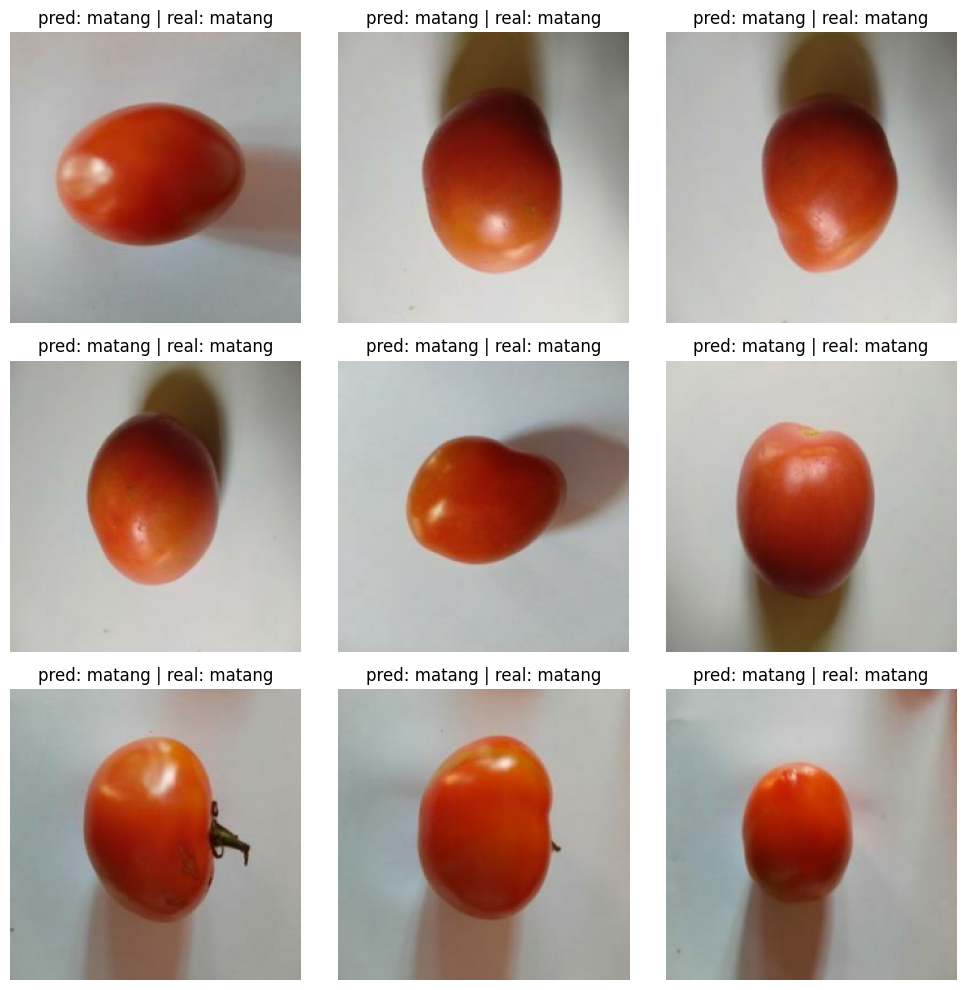

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    probs = model(images, training=False).numpy()

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_idx = int(np.argmax(probs[i]))
        true_idx = int(labels[i])
        plt.title(f"pred: {class_names[pred_idx]} | real: {class_names[true_idx]}")
        plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_filename = "klasiftomatv3.tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

print("Selesai export:", tflite_filename)


Saved artifact at '/tmp/tmp8sj48h1w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_207')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133554848073488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848074832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848075024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848073872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848073296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848074064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848076944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848077136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848075984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133554848074640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335548480